# Andor Full Vertical Binning for Resolving Single Photon O2 Fluorescence 

## Intro

Modifications to Data Acquisition (DAQ) system to enable data collection with slow cameras increases the number of configurations that prevent the DAQ from operating.  The goal here is to show that O2 photons can be identified in higher level noise present during full vertical binning by using fourier domain filtering to digitally attenuate the readout noise.

This was demoed on a Cu data with andor in full vertical binning set to show improved SNR

## Loading Libraries

In [3]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter

## Initializing Data

### Loading Data

In [4]:
#load data
experiment_run_name = "xpptut15run360.h5"       #this contains
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

### Converting hdf5 to Python Dictionary

In [5]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    try:
        my_dict[i] = array(my_hdf5_object[i])
    except:
        pass

In [6]:
 my_dict['andor/image/orig'] = 0+ my_dict['andor/image']

In [7]:
#removing offsets
my_dict['andor/image'] = my_dict['andor/image/orig'][0]-mean(my_dict['andor/image/orig'][0][:100])
for i in arange(1,len(my_dict['andor/image'])):
    #my_dict['andor/image'][i]=my_dict['andor/image/orig'][i]- mean(my_dict['andor/image/orig'][i][:100])
    my_dict['andor/image'] = vstack([my_dict['andor/image'] ,my_dict['andor/image/orig'][i]-mean(my_dict['andor/image/orig'][i][:100])])

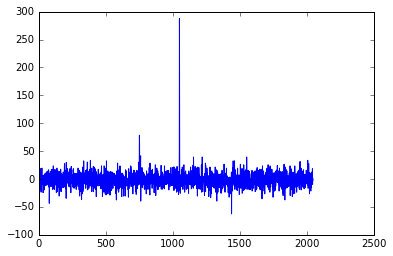

In [8]:
plot(my_dict['andor/image/orig'][100]-mean(my_dict['andor/image/orig'][100][:100]))
show()

## Visualizing Some Sample Data

### some single shots

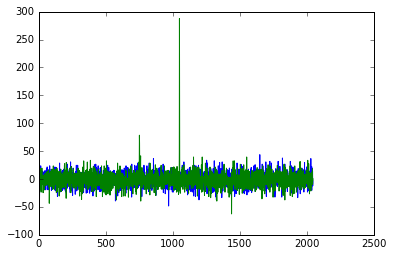

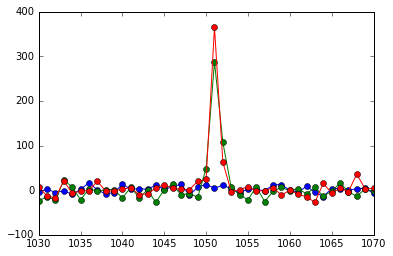

In [9]:
#plot some sample data
plot(my_dict['andor/image'][0])
plot(my_dict['andor/image'][100])
show()
plot(my_dict['andor/image'][0],'o-')
plot(my_dict['andor/image'][100],'o-')
plot(my_dict['andor/image'][200],'o-')
xlim(1030,1070)
show()

## Histogram of photon intensities

### comparing with signal vs thresholded noise

In [10]:
def outlier_removal(y,window_size):
    #smoothed = convolve(y,ones(window_size)*1.0/window_size,mode="same")
    smoothed = medfilt(y,window_size)
    stan_dev = std(y-smoothed)

    to_return = []
    for i in arange(len(y)):
        if (abs(y[i]-smoothed[i])>2.5*stan_dev):
            #to_return.append(smoothed[i])
            to_return.append(-9)
        else:
            to_return.append(y[i])
    return to_return

In [11]:
window_size = 11
my_noise = outlier_removal(my_dict['andor/image'].flatten(),window_size)   #just looking at the noise

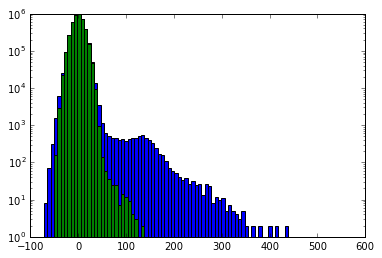

In [12]:
hist(my_dict['andor/image'].flatten(),bins=arange(-100,600,7),log=True)
hist(my_noise,bins=arange(-100,600,7),log=True)
show()

### comparing fourier filtered histogram with regular histogram

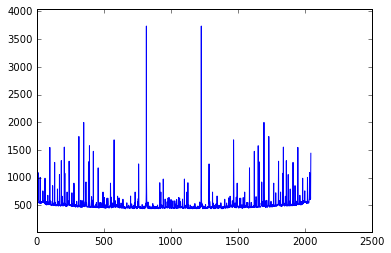

In [13]:
#find location of of largest noise term
my_power_spectrum = mean(abs(fft(my_dict['andor/image'],axis=1)), axis=0)
plot(my_power_spectrum)
ylim(e**3,0.5*e**9)
show()

In [ ]:
n_events=1000
fourier_filter_images = fft(my_dict['andor/image'],axis=1)
for i in arange(n_events):
    temp_power_spectrum = mean(abs(fourier_filter_images[:n_events]), axis=0)
    my_arg_max = argmax(temp_power_spectrum)
    my_max = temp_power_spectrum[my_arg_max]
    #print(my_arg_max)
    #print(my_max)
    #print(i)
    
    fourier_filter_images[:,my_arg_max] *=500.0/my_max
    fourier_filter_images[:,len(my_power_spectrum)-my_arg_max-1] *=500.0/my_max

corrected_image = real(ifft(fourier_filter_images,axis=1))


In [32]:
my_dict['andor/image'].shape

(2048, 2048)

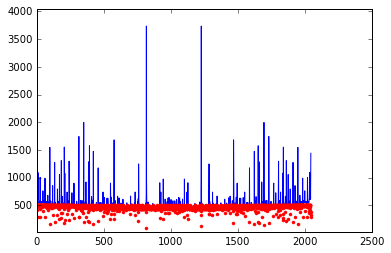

In [15]:
plot(mean(abs(fft(my_dict['andor/image'],axis=1)), axis=0),'b-')
plot(temp_power_spectrum,'r.')
ylim(e**3,0.5*e**9)
show()

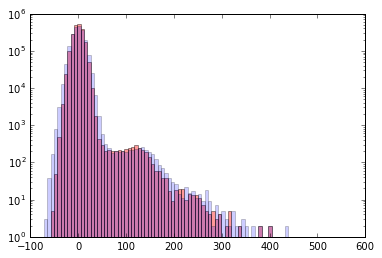

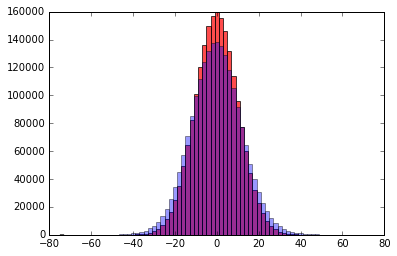

In [16]:
bin_start = -100
bin_end= 600
hist(corrected_image[:n_events].flatten(),bins=arange(bin_start,bin_end,7),log=True,alpha=0.4,color='r')
hist(my_dict['andor/image'][:n_events].flatten(),bins=arange(bin_start,bin_end,7),log=True,alpha=0.2)
show()

hist(corrected_image[:n_events].flatten(),bins=arange(-75,75,2),alpha=0.7,color='r')
hist(my_dict['andor/image'][:n_events].flatten(),bins=arange(-75,75,2),alpha=0.4)

show()


In [17]:
print(std(my_noise))
print(std(outlier_removal(corrected_image[:n_events].flatten(),window_size)))
#print(std(corrected_image[:n_events].flatten()))

11.8214166281
9.95250575571


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


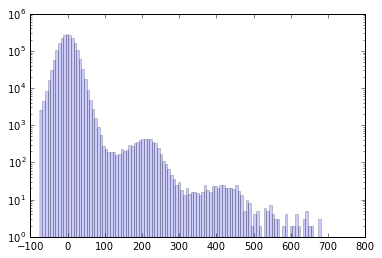

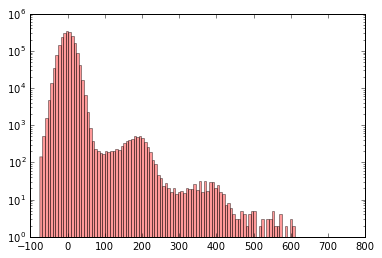

In [18]:
window_size = 3.0
pseudo_large_pixel = convolve(corrected_image[:n_events].flatten(),ones(window_size))
hist(convolve(my_dict['andor/image'][:n_events].flatten(),ones(window_size)),bins=arange(-75,750,7),alpha=0.2,log=True)

show()

hist(pseudo_large_pixel,bins=arange(-75,750,7),alpha=0.4,color='r',log=True)

show()


## comparing effects of thresholding on photon count

### Brute Force Sum

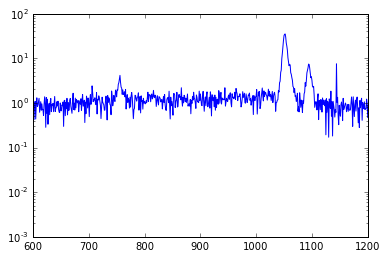

In [19]:
plot(1+mean(my_dict['andor/image'],axis=0))
semilogy()
xlim(600,1200)
show()

### Thresholded sum

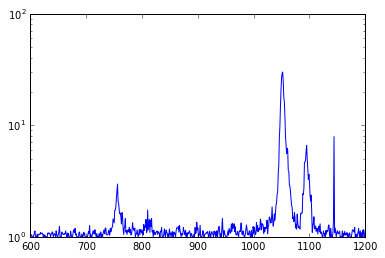

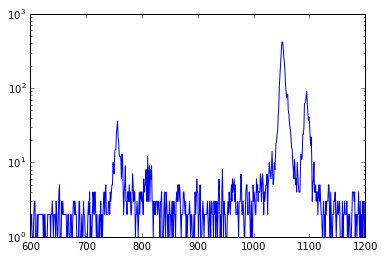

In [72]:
threshold_mask = my_dict['andor/image']<70
thresholded_data = 0+ my_dict['andor/image']
thresholded_data[threshold_mask]=0
plot(1+mean(thresholded_data,axis=0))
semilogy()
xlim(600,1200)
show()

plot(1+sum(thresholded_data>70,axis=0))
xlim(600,1200)
semilogy()
show()

### Fourier corrected and thresholded sum

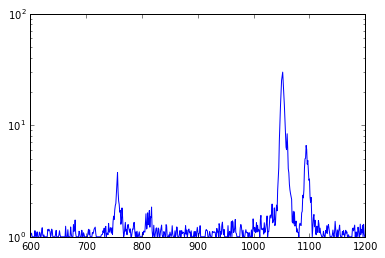

In [66]:
#plot(2+mean(corrected_image[:n_events],axis=0))

threshold_mask = corrected_image[:n_events]<40
thresholded_data = 0+ corrected_image[:n_events]
thresholded_data[threshold_mask]=0

plot(1+mean(thresholded_data,axis=0))

semilogy()
xlim(600,1200)
show()

## Gaussian fitting for filtering

### definning gaussian for fitting

In [95]:
def gaussian(x, x0,sigma,a):
    sigma_min = 0.001
    #return a*exp(-(x-x0)**2/(2*sigma**2))+4e-2
    return a*exp(-(x-1.0*x0)**2/(2*(sigma**2+sigma_min**2)))

### iterative gaussian fitting

In [96]:
def get_peaks(my_spectra):
    energy = arange(len(my_spectra))
    num_peaks = 5            #number of peaks to fit to
    working_area = 10           #use a window this big
    initial_positions = argsort(my_spectra)[-num_peaks:]     #get num_peaks with the largest pixels
    initial_amplitudes = my_spectra[initial_positions]*1.0   #and their largest pixel value
    known_good_region = 2000                                 #ignore pixels too close to the array boundary

    my_fits = [0,0,0,0]                                      #need to start for vstack to work

    for i in arange(num_peaks):
        try:
            #this if is to avoid out of array range problems
            if((initial_positions[i]>working_area and initial_positions[i]<(len(energy)-working_area)) and initial_positions[i]< known_good_region):
                y = my_spectra[initial_positions[i]-working_area:initial_positions[i]+working_area]    #select area around peak
                x = energy[initial_positions[i]-working_area:initial_positions[i]+working_area]        #select area around peak

                #popt,pcov = curve_fit(gaussian,x,y,p0=[initial_positions[i]*1.0,0.1,initial_amplitudes[i]])  #actual gaussian fitting
                x_temp = arange(len(x))
                popt,pcov = curve_fit(gaussian,x,convolve(y,gaussian(x_temp,len(x)/2.0,2,1),mode='same'),p0=[initial_positions[i]*1.0,0.1,initial_amplitudes[i]])  #actual gaussian fitting
                my_fits = vstack([my_fits,[initial_positions[i],popt[0],popt[1],popt[2]]])                   #append the fit to the fit list

                #IPython.embed()
                my_spectra[initial_positions[i]-working_area:initial_positions[i]+working_area]-=0           #remove peak so it doesn't get fit twice. (this will suppress two photon events that are close to each other)

            else:
                my_fits = vstack([my_fits,[initial_positions[i],0,0,0]])              #if this fit is out of bounds, just append zeros

        except RuntimeError:
            #IPython.embed()
            #pass
            my_fits = vstack([my_fits,[initial_positions[i],0,0,0]])

    return my_fits[1:]                  #don't return the first set of zeros

In [97]:
my_amplitudes = array([])
my_energies_fine = array([])
my_energies_coarse = array([])
my_sigmas = array([])

my_counter = 0
#data = my_dict['andor/image']
data = corrected_image
mybgk = np.mean(data,axis=0) 

for my_spectra in my_dict['andor/image']:
    my_spectra=my_spectra-mybgk
    my_median= median(my_spectra)
    #for i in arange(5):
        #my_spectra[i::5]=my_spectra[i::5]-median(my_spectra[i::5])+my_median #fourier filtering. already filtered earlier

    my_fit = get_peaks(my_spectra)
    my_amplitudes = append(my_amplitudes, my_fit[:,3])	
    my_energies_coarse = append(my_energies_coarse,my_fit[:,0])
    my_energies_fine = append(my_energies_fine,my_fit[:,1])
    my_sigmas = append(my_sigmas,my_fit[:,2])
    if(my_counter%100==0):
        print(my_counter)
    my_counter +=1



/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


### Displaying Results

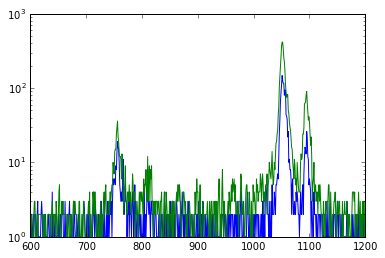

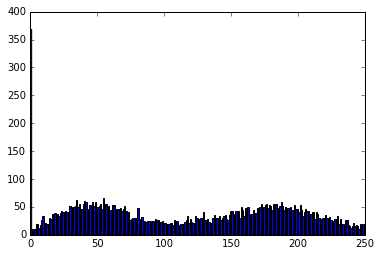

In [101]:
#hist(my_energies_coarse[my_amplitudes*(my_sigmas**2+1.0**2)**0.5>55],bins=arange(2048))

temp_mask = my_amplitudes>70 
temp_mask *=(my_amplitudes<160)
ssy, ssx = histogram(my_energies_fine[temp_mask],bins=arange(2048))

plt.figure()
plt.plot(ssx[1:],1+ssy)
plot(1+sum(thresholded_data>70,axis=0))
semilogy()
xlim(600,1200)
show()

hist(my_amplitudes,bins=arange(250))
show()

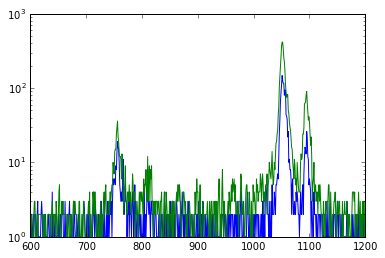

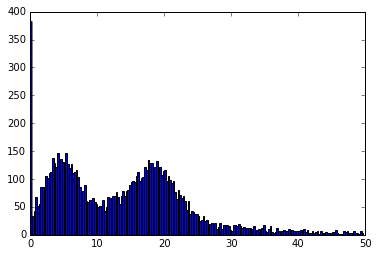

In [103]:
#hist(my_energies_coarse[my_amplitudes*(my_sigmas**2+1.0**2)**0.5>55],bins=arange(2048))

temp_mask = my_amplitudes>70 
temp_mask *=(my_amplitudes<160)
ssy, ssx = histogram(my_energies_fine[temp_mask],bins=arange(2048))

plt.figure()
plt.plot(ssx[1:],1+ssy)
plot(1+sum(thresholded_data>70,axis=0))
semilogy()
xlim(600,1200)
show()

hist(my_amplitudes*my_sigmas,bins=arange(0,50,.25))
show()